In [7]:
import pyautogui
import os
import time
import pydirectinput
import numpy as np
from PIL import Image
import pytesseract
import re
import difflib
import logging
import pygetwindow as gw
import hashlib
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

        
first_rectangle_top_left_x = 477
first_rectangle_top_left_y = 1007
first_rectangle_bottom_right_x = 1001
first_rectangle_bottom_right_y = 1078

first_rectangle_top_right_x = 1012

width = first_rectangle_bottom_right_x - first_rectangle_top_left_x
height = first_rectangle_bottom_right_y - first_rectangle_top_left_y

class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    def __str__(self):
        return f"Rectangle(x={self.x}, y={self.y}, width={self.width}, height={self.height})"
    

reference_rectangle_list = [
Rectangle(489,990, 1003 - 489, 1059 - 990),


Rectangle(489,1062, 1003 - 489, 1131 - 1062),


Rectangle(489,1133, 1003 - 489, 1202 - 1133),


Rectangle(489,1204, 1003 - 489, 1274 - 1204),

###

Rectangle(1017,990, 1553 - 1017, 1059 - 990),


Rectangle(1017,1062, 1553 - 1017, 1131 - 1062),


Rectangle(1017,1133, 1553 - 1017, 1202 - 1133),


Rectangle(1017,1204, 1553 - 1017, 1274 - 1204),

]

veriification_rectangle = Rectangle(467, 83, 657 - 467, 145 - 83)

exp_veriification_rectangle =  Rectangle(1578,751,2070-1578,1011-751)


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # replace with your actual path

custom_config = r'--tessdata-dir "C:\Program Files\Tesseract-OCR\tessdata" --psm 13'

def timer(seconds):
    # Start a 5-second timer
    for i in range(seconds, 0, -1):
        print(f"Remaining: {i} seconds")
        time.sleep(1)

def timed_input(seconds, key):
    pydirectinput.press(key)
    time.sleep(seconds)

counter = 0

class SkillAnalyzer():

    def __init__(self, recipe_controllers):

        self.recipe_controllers = recipe_controllers

    

    def check_window_change(self,active_window_title):
        # Check if the active window has changed
        if gw.getActiveWindow().title != active_window_title:
            print('Active window has changed. Stopping the program.')
            return True
        return False

        

    def define_verification_rectangle(self):
        verify_image = pyautogui.screenshot(region=(veriification_rectangle.x, veriification_rectangle.y, veriification_rectangle.width, veriification_rectangle.height))
        
        # Convert the image to bytes
        image_bytes = verify_image.tobytes()

        # Create a hash of the image
        image_hash = hashlib.sha256(image_bytes).hexdigest()

        self.verification_hash = image_hash

    def define_exp_verification_rectangle(self):
        verify_exp_image = pyautogui.screenshot(region=(exp_veriification_rectangle.x, exp_veriification_rectangle.y, exp_veriification_rectangle.width, exp_veriification_rectangle.height))

        verify_exp_image_bytes = verify_exp_image.tobytes()

        verify_exp_image_hash = hashlib.sha256(verify_exp_image_bytes).hexdigest()

        self.verification_hash_exp = verify_exp_image_hash




    def verify_rectangle(self):
        verify_image = pyautogui.screenshot(region=(veriification_rectangle.x, veriification_rectangle.y, veriification_rectangle.width, veriification_rectangle.height))


        verify_exp_image = pyautogui.screenshot(region=(exp_veriification_rectangle.x, exp_veriification_rectangle.y, exp_veriification_rectangle.width, exp_veriification_rectangle.height))
        
        # Convert the image to bytes
        image_bytes = verify_image.tobytes()

        verify_exp_image_bytes = verify_exp_image.tobytes()

        # Create a hash of the image
        image_hash = hashlib.sha256(image_bytes).hexdigest()

        verify_exp_image_hash = hashlib.sha256(verify_exp_image_bytes).hexdigest()

        if image_hash != self.verification_hash or verify_exp_image_hash != self.verification_hash_exp:
            if image_hash != self.verification_hash:
                print('Verification rectangle has changed. Stopping the program.')
                plt.imshow(verify_image)
            
            if verify_exp_image_hash != self.verification_hash_exp:
                print('EXP Verification rectangle has changed. Stopping the program.')
                plt.imshow(verify_exp_image)

            print('showing bad pictures')
            plt.show()
            return True

        return False


    def changeSpecialFusion(self):
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')
        # Press the 'l' key
        pydirectinput.press('l')
        # Press the 'm' key
        timed_input(0.1, 'm')
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')


    def change3wayFusion(self):
        for i in range(3):
            # Press the 'l' key
            timed_input(0.1, 'l')

        timed_input(0.1, 'm')
        
        for i in range(2):
            # Press the 'l' key
            #timed_input(0.1, 't')
            timed_input(0.1, 'g')
            
        
        timed_input(0.01, 'm')

        for i in range(1):
            # Press the 'l' key
            #timed_input(0.01, 't')
            timed_input(0.01, 'g')
            
        # Press the 'm' key
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')
        timed_input(0.1, 'm')
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')

    def calculate_similarity_matrix(self,targets, references):
        matrix = np.zeros((len(targets), len(references)))
        for i, target in enumerate(targets):
            for j, reference in enumerate(references):
                score = difflib.SequenceMatcher(None, target, reference).ratio()
                matrix[i][j] = -score  # Negative score because we minimize cost
        return matrix
    
    def find_best_unique_matches(self,targets, references):
        similarity_matrix = self.calculate_similarity_matrix(targets, references)
        row_ind, col_ind = linear_sum_assignment(similarity_matrix)
        matches = {targets[i]: references[j] for i, j in zip(row_ind, col_ind)}
        sorted_matches = {target: matches[target] for target in targets if target in matches}

        return sorted_matches


    def get_images(self, recipe_controller,overall_counter):

        found_skills = []
        rec_counter = 0
        text_strips = []
        for rectangle in recipe_controller.rectangle_list:
        
            # Take a screenshot of the rectangle
            cropped_img = pyautogui.screenshot(region=(rectangle.x, rectangle.y, rectangle.width, rectangle.height))
            
            directory = "C:\\Users\\Eduardo\\Pictures\\Screenshots\\persona3\\{}\\{}\\{}\\".format(recipe_controller.logger_name,recipe_controller.result_persona_name, overall_counter)

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            image_path = directory + "{}.png".format(rec_counter)

            cropped_img.save(image_path)

            #plt.imshow(cropped_img)
            #plt.show()
            #test
            #cropped_img = img.crop((rectangle.x, rectangle.y, rectangle.x + rectangle.width, rectangle.y + rectangle.height))

            # Convert the image to RGB
            rgb_img = cropped_img.convert('RGB')

            hex_color = '65dfcd'

            # Convert the target hex color to RGB
            target_r, target_g, target_b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
            target_color = np.array([target_r, target_g, target_b])

            # Convert the image to a NumPy array
            img_array = np.array(rgb_img)

            # Calculate the Euclidean distance between each pixel's color and the target color
            color_distance = np.linalg.norm(img_array - target_color, axis=2)

            # Create a mask for pixels that are similar to the target color
            mask = color_distance < 65

            # Change the color of the pixels based on the mask
            img_array[mask] = [0, 0, 0]  # black
            img_array[~mask] = [255, 255, 255]  # white

            # Convert the NumPy array back to an image
            rgb_img = Image.fromarray(img_array)

            # Convert the image to grayscale
            gray_img = rgb_img.convert('L')

            # Apply a threshold to make it binary
            binary_img = gray_img.point(lambda x: 0 if x<128 else 255, '1')

            text_tesseract = pytesseract.image_to_string(binary_img, config=custom_config)
            
            # 'remove all characters that are not letters, numbers, ' ' or '-'
            text_re = re.sub(r'[^a-zA-Z0-9 -]', '', text_tesseract)

            # remove ' ' and '-' from the beginning and end of the string
            text_strip = text_re.strip(' -')


            text_strips.append(text_strip)

            rec_counter += 1

        
            ''' 
            match = difflib.get_close_matches(text_strip, recipe_controller.skill_set, n=1, cutoff=0.0)

            if match:
                best_match = match[0]
            else:
                best_match = ''  # No match found

            text_path = directory + "{}.txt".format(rec_counter)

            #write 'best_match' to a file
            with open(text_path, 'w') as file:
                file.write(best_match)

            rec_counter += 1
            found_skills.append(best_match)
            '''
        
        matches = self.find_best_unique_matches(text_strips, recipe_controller.skill_set)

        rec_counter = 0
        for target, match in matches.items():
            text_path = directory + "{}.txt".format(rec_counter)
            #write 'best_match' to a file
            with open(text_path, 'w') as file:
                file.write(match)
            found_skills.append(match)
            rec_counter += 1
            
        
        return found_skills
    
    def verify_duplicate(self, predictions):
        return len(predictions) != len(set(predictions))
        
    
    def cycle(self):
        global counter

        timer(3)
        # Press the right key
        #pydirectinput.keyDown('up')
        #pydirectinput.keyUp('up')
        # Get the title of the currently active window
        self.define_verification_rectangle()
        active_window_title = gw.getActiveWindow().title
        predict = True

        for recipe_controller in self.recipe_controllers:
            ''' 
            if recipe_controller.save_state_slot != 2 and recipe_controller.save_state_slot != 8:
                continue
            '''
            

            


            pydirectinput.keyDown(recipe_controller.save_state_slot_load)
            pydirectinput.keyUp(recipe_controller.save_state_slot_load)
            time.sleep(1)
            self.define_exp_verification_rectangle()
            counter = 0
            reoccuring_fail = False

            
            ''' 
            if recipe_controller.save_state_slot == 2:
                counter = 1000
            
            if recipe_controller.save_state_slot == 8:
                counter = 1000
            '''
            


            while counter < 10000:
                
                if self.check_window_change(active_window_title):
                    break

                if self.verify_rectangle():
                    pydirectinput.keyDown(recipe_controller.save_state_slot_load)
                    pydirectinput.keyUp(recipe_controller.save_state_slot_load)
                    predict = False
                    if reoccuring_fail:
                        break
                    reoccuring_fail = True
                    counter -=1
                #print("wating to save in key: ".format(recipe_controller.save_state_slot))
                pydirectinput.keyDown(recipe_controller.save_state_slot_save)
                pydirectinput.keyUp(recipe_controller.save_state_slot_save)

                predictions = self.get_images(recipe_controller,counter)
                
                if self.verify_duplicate(predictions):
                    predict = False
                    counter -=1
                    break

                # Log the predictions vector
                if predict:
                    reoccuring_fail = False
                    recipe_controller.logger.info(f'{predictions}')
                    print(predictions)
                else:
                    predict = True

                if self.check_window_change(active_window_title):
                    break
                
                if recipe_controller.fusion_spread_type == 'special':
                    self.changeSpecialFusion()
                    counter +=1
                elif recipe_controller.fusion_spread_type == '3way':
                    self.change3wayFusion()
                    counter +=1
            print('swaping to next save state')
        

        
class RecipeController():

    def __init__(self, persona_inherit_type,recipe_file_name,skill_set, base_skills_amount, inherit_slots_amount, result_persona_name, fusion_spread_type, save_state_slot ):

        # Unique logger name for each RecipeController instance
        logger_name = f'Logger_{recipe_file_name}_{save_state_slot}_{result_persona_name}'
        self.logger = logging.getLogger(logger_name)

        self.logger_name = logger_name

        # Prevent logger from propagating messages to ancestor loggers
        self.logger.propagate = False

        # Clear existing handlers (if any) and set a new file handler
        self.logger.handlers.clear()
        self.logger.setLevel(logging.INFO)

        # verify and make directory 'predictions'
        if not os.path.exists('predictions_{}'.format(persona_inherit_type)):
            os.makedirs('predictions_{}'.format(persona_inherit_type))
        

        file_handler = logging.FileHandler(f'predictions_{persona_inherit_type}\\predictions_{recipe_file_name}_{save_state_slot}.log')
        self.logger.addHandler(file_handler)

        self.skill_set = skill_set
        self.base_skills_amount = base_skills_amount

        # Telos has special ammount of inherits
        if result_persona_name == 'orpheus telos':
            inherit_slots_amount = 8
        self.inherit_slots_amount = inherit_slots_amount

        start, end = self.base_skills_amount, self.inherit_slots_amount + self.base_skills_amount
        number_list = list(range(start, end))


        rectangle_list = []

        y = first_rectangle_top_left_y
        
        ''' 
        for i in number_list:
            if i < 4:
                x = first_rectangle_top_left_x 
            else:
                x = first_rectangle_top_right_x
            rec = Rectangle(x,y + (height * (i % 4)), width, height)
            rectangle_list.append(rec)
        '''
        for i in number_list:
             rectangle_list.append(reference_rectangle_list[i])

        

        self.rectangle_list = rectangle_list
        #

        self.result_persona_name = result_persona_name
        self.fusion_spread_type = fusion_spread_type

        self.save_state_slot = save_state_slot

        self.save_state_slot_save = "f{}".format(self.save_state_slot)

        if self.save_state_slot == 10:
            self.save_state_slot_load = "0"
        else:
            self.save_state_slot_load = str(self.save_state_slot)

    def __str__(self):
        return f"RecipeController(skill_set={self.skill_set}, base_skills_amount={self.base_skills_amount}, inherit_slots_amount={self.inherit_slots_amount}, result_persona_name={self.result_persona_name}, fusion_spread_type={self.fusion_spread_type}, save_state_slot={self.save_state_slot})\n"
    
    def __repr__(self):
        return f"RecipeController(skill_set={self.skill_set}, base_skills_amount={self.base_skills_amount}, inherit_slots_amount={self.inherit_slots_amount}, result_persona_name={self.result_persona_name}, fusion_spread_type={self.fusion_spread_type}, save_state_slot={self.save_state_slot})\n"

def parse_personas(persona_string):
    return re.findall(r"\('([\w\s-]+)', \d+, '([\w\s]+)'\)", persona_string)


def parse_skills(skill_string):
    return [skill.strip().strip("'").strip('"') for skill in skill_string.strip('[]').split(',')]

def parse_file(file_content,recipe_file_name,persona_inherit_type):
    recipes = []
    sections = file_content.split('------------------------\n')

    for section in sections:
        if section.strip() == '':
            continue

        personas = re.findall(r"Personas: \[([^\]]+)\]", section)
        skills = re.findall(r"Skills: \[([^\]]+)\]", section)
        result_persona = re.search(r"Resulting Persona: ([\w\s]+?)\s*$", section, re.MULTILINE)
        base_skills_amount = re.search(r"Base Skills Ammount: (\d+)", section)
        inherit_slots_amount = re.search(r"Inherited Skills Ammount: (\d+)", section)
        save_state_slot = re.search(r"key f(\d+)", section)

        if personas and skills and result_persona and base_skills_amount and inherit_slots_amount and save_state_slot:
            persona_list = parse_personas(personas[0])
            #print(persona_list)
            skill_set = parse_skills(skills[0])
            base_skills_amount = int(base_skills_amount.group(1))
            inherit_slots_amount = int(inherit_slots_amount.group(1))
            result_persona_name = result_persona.group(1).strip()
            fusion_spread_type = '3way' if len(persona_list) == 3 else 'special'
            save_state_slot = int(save_state_slot.group(1))

            recipe = RecipeController(persona_inherit_type,recipe_file_name,skill_set, base_skills_amount, inherit_slots_amount, result_persona_name, fusion_spread_type, save_state_slot)
            recipes.append(recipe)

    return recipes

# Example usage:

#open the file
file_name = 'logs-ALL-optimal_recipes_part3.txt'
persona_inherit_type = 'ALL'
with open('C:\\Users\\Eduardo\\Documents\\Projects\\AutoTelos\\Persona3FES-FusionHelper\\fusion_navigator\\logs_optimal_solutions\\logs_definitive\\{}'.format(file_name), 'r') as file:
    file_content = file.read()
    recipes = parse_file(file_content,file_name,persona_inherit_type)


In [8]:
print(recipes)

[RecipeController(skill_set=['Wind Amp', 'Rakunda', 'Brave Blade', 'Tempest Slash', 'Spell Master', 'Fire Amp', 'Sukukaja', 'Mamudoon', 'Wind Boost', 'Agi', 'Magarudyne', 'Auto-Rakukaja', 'Makarakarn', 'Deathbound', 'Diarama', 'High Counter', 'Bash', 'Maragidyne', 'Megidolaon', 'Victory Cry'], base_skills_amount=3, inherit_slots_amount=4, result_persona_name=loki, fusion_spread_type=3way, save_state_slot=1)
]


Remaining: 3 seconds
Remaining: 2 seconds
Remaining: 1 seconds
['Maragidyne', 'Bash', 'Deathbound', 'Agi']
['Agi', 'Diarama', 'Makarakarn', 'Sukukaja']
['Rakunda', 'Sukukaja', 'Agi', 'Bash']
['Bash', 'Sukukaja', 'High Counter', 'Rakunda']
['Megidolaon', 'Bash', 'Diarama', 'Rakunda']
['Brave Blade', 'Maragidyne', 'Agi', 'Victory Cry']
['Bash', 'Wind Boost', 'Maragidyne', 'Agi']
['Diarama', 'Agi', 'Wind Boost', 'Rakunda']
['Sukukaja', 'Wind Amp', 'Agi', 'Magarudyne']
['Bash', 'Sukukaja', 'Victory Cry', 'Wind Boost']
['Diarama', 'Maragidyne', 'Wind Amp', 'Magarudyne']
['Bash', 'Agi', 'High Counter', 'Mamudoon']
['Wind Amp', 'Auto-Rakukaja', 'Rakunda', 'Mamudoon']
['Bash', 'Rakunda', 'Wind Boost', 'Deathbound']
['Bash', 'Sukukaja', 'Tempest Slash', 'Rakunda']
['Diarama', 'Maragidyne', 'Bash', 'Agi']
['Agi', 'Auto-Rakukaja', 'High Counter', 'Fire Amp']
['Wind Boost', 'Sukukaja', 'Bash', 'Auto-Rakukaja']
['Agi', 'Maragidyne', 'Bash', 'Brave Blade']
['Wind Amp', 'Fire Amp', 'Agi', 'Spell Mast

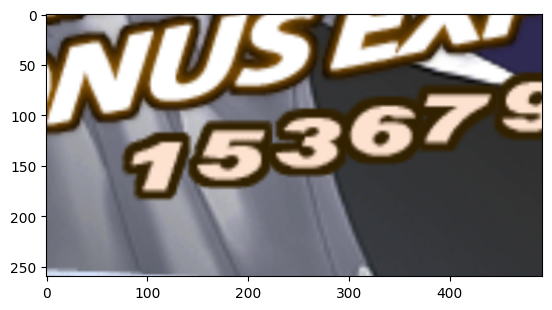

['Sukukaja', 'Magarudyne', 'Megidolaon', 'Brave Blade']
['Magarudyne', 'Wind Boost', 'Mamudoon', 'Agi']
['Agi', 'Fire Amp', 'Wind Boost', 'Makarakarn']
['Sukukaja', 'High Counter', 'Rakunda', 'Fire Amp']
['Rakunda', 'Sukukaja', 'Wind Amp', 'Bash']
['Sukukaja', 'Diarama', 'Bash', 'Wind Boost']
['Wind Amp', 'Magarudyne', 'Maragidyne', 'Tempest Slash']
['Makarakarn', 'Auto-Rakukaja', 'Wind Amp', 'Agi']
['Sukukaja', 'Tempest Slash', 'Bash', 'Wind Amp']
['Auto-Rakukaja', 'Agi', 'Diarama', 'Megidolaon']
['Tempest Slash', 'Diarama', 'Bash', 'Magarudyne']
['Rakunda', 'Deathbound', 'Fire Amp', 'Bash']
['Mamudoon', 'Bash', 'Diarama', 'Deathbound']
['Wind Boost', 'Spell Master', 'Rakunda', 'Auto-Rakukaja']
['Maragidyne', 'Tempest Slash', 'Fire Amp', 'Agi']
['Wind Amp', 'Bash', 'Rakunda', 'Magarudyne']
['Diarama', 'Sukukaja', 'Bash', 'High Counter']
['Rakunda', 'Auto-Rakukaja', 'Bash', 'Deathbound']
['Spell Master', 'Fire Amp', 'Bash', 'Deathbound']
['Sukukaja', 'Bash', 'Brave Blade', 'Magarudyne'

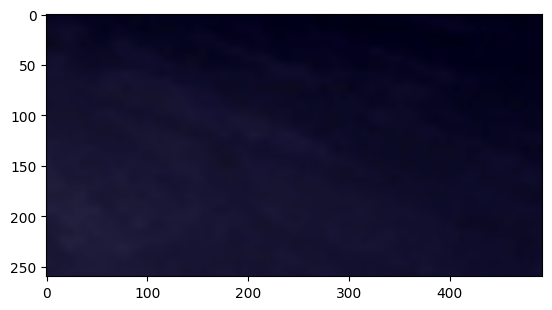

['Bash', 'Mamudoon', 'Magarudyne', 'Sukukaja']
['Sukukaja', 'Diarama', 'Agi', 'Maragidyne']
['Sukukaja', 'Maragidyne', 'Deathbound', 'Bash']
['Maragidyne', 'Mamudoon', 'Bash', 'Rakunda']
['Brave Blade', 'Diarama', 'Auto-Rakukaja', 'Magarudyne']
['Agi', 'Diarama', 'Tempest Slash', 'Mamudoon']
['Sukukaja', 'Wind Amp', 'Agi', 'Bash']
['High Counter', 'Rakunda', 'Diarama', 'Tempest Slash']
['Diarama', 'Wind Boost', 'Deathbound', 'Makarakarn']
['Diarama', 'Spell Master', 'Bash', 'Auto-Rakukaja']
['Tempest Slash', 'Fire Amp', 'Bash', 'Rakunda']
['Wind Amp', 'Diarama', 'Bash', 'Fire Amp']
['Rakunda', 'High Counter', 'Sukukaja', 'Auto-Rakukaja']
['Sukukaja', 'Maragidyne', 'Auto-Rakukaja', 'Tempest Slash']
['Bash', 'Sukukaja', 'Brave Blade', 'Spell Master']
['Bash', 'Brave Blade', 'Magarudyne', 'Diarama']
['Mamudoon', 'Sukukaja', 'Bash', 'Diarama']
['Diarama', 'Fire Amp', 'High Counter', 'Bash']
['Sukukaja', 'Wind Boost', 'Diarama', 'Magarudyne']
['Bash', 'Rakunda', 'Fire Amp', 'Wind Boost']
['

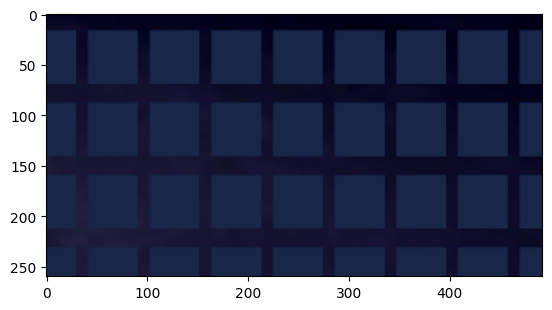

['Wind Boost', 'Makarakarn', 'Agi', 'Diarama']
['Bash', 'Diarama', 'Fire Amp', 'Mamudoon']
['Agi', 'Fire Amp', 'Bash', 'Wind Boost']
['Bash', 'Mamudoon', 'Brave Blade', 'Wind Amp']
['High Counter', 'Sukukaja', 'Bash', 'Diarama']
['Mamudoon', 'Makarakarn', 'Fire Amp', 'Deathbound']
['Agi', 'Maragidyne', 'Brave Blade', 'Wind Boost']
['Fire Amp', 'Auto-Rakukaja', 'Wind Boost', 'Diarama']
['Wind Boost', 'Agi', 'Auto-Rakukaja', 'Spell Master']
['Wind Boost', 'Makarakarn', 'Rakunda', 'Diarama']
['Agi', 'Sukukaja', 'Wind Amp', 'Bash']
['Wind Boost', 'Fire Amp', 'Rakunda', 'Bash']
['Wind Boost', 'Wind Amp', 'Agi', 'Bash']
['Bash', 'Rakunda', 'Wind Boost', 'Magarudyne']
['Wind Boost', 'Magarudyne', 'Megidolaon', 'Spell Master']
['Makarakarn', 'Fire Amp', 'Spell Master', 'Wind Amp']
['Deathbound', 'Agi', 'Bash', 'Fire Amp']
['Rakunda', 'Tempest Slash', 'Maragidyne', 'Deathbound']
['Fire Amp', 'Diarama', 'Tempest Slash', 'Agi']
['Victory Cry', 'Bash', 'Magarudyne', 'Auto-Rakukaja']
['Magarudyne',

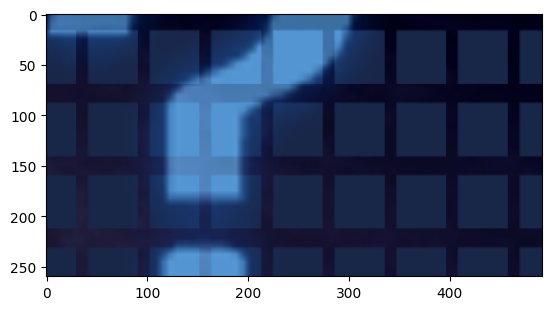

['Bash', 'Agi', 'Spell Master', 'Fire Amp']
['Bash', 'Brave Blade', 'Wind Boost', 'Agi']
['Diarama', 'Wind Amp', 'Wind Boost', 'Fire Amp']
['Sukukaja', 'Agi', 'Diarama', 'Bash']
['Agi', 'Victory Cry', 'Bash', 'Sukukaja']
['Agi', 'Makarakarn', 'Sukukaja', 'Auto-Rakukaja']
['Tempest Slash', 'Diarama', 'Bash', 'Auto-Rakukaja']
['Mamudoon', 'Fire Amp', 'Spell Master', 'Diarama']
['Auto-Rakukaja', 'Bash', 'Sukukaja', 'Brave Blade']
['Fire Amp', 'Agi', 'Wind Amp', 'Diarama']
['Wind Boost', 'Deathbound', 'Rakunda', 'Makarakarn']
['Magarudyne', 'Wind Boost', 'Wind Amp', 'Auto-Rakukaja']
['Sukukaja', 'Bash', 'Agi', 'Deathbound']
['Sukukaja', 'Wind Boost', 'Magarudyne', 'Rakunda']
['Bash', 'Victory Cry', 'Auto-Rakukaja', 'Sukukaja']
['Bash', 'Deathbound', 'Magarudyne', 'Rakunda']
['Maragidyne', 'Bash', 'Agi', 'Megidolaon']
['Agi', 'Bash', 'Sukukaja', 'Fire Amp']
['Bash', 'Agi', 'Fire Amp', 'Makarakarn']
['Megidolaon', 'Wind Amp', 'Sukukaja', 'Makarakarn']
['Agi', 'Magarudyne', 'Auto-Rakukaja', '

In [9]:
sa = SkillAnalyzer(recipes)
sa.cycle()

In [14]:

keys = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12',
    'enter', 'ctrl', 'alt', 'tab', 'shift', 'backspace', 'capslock', 'esc', 'space', 'delete', 'insert', 'home', 'end', 'up', 'down', 'left', 'up',
    'pageup', 'pagedown', 'printscreen', 'pause', 'numlock', 'scrolllock',
]

In [4]:
print(counter)

614


refazer slot 4 

comecar slot 9 do 614